# Overlapping Generation Model
## 3-period-lived Agents with Exogenous Labor Supply


Prof. Richard Evans

Author: Martina Fraschini

In [1]:
# import packages
import numpy as np
import time
from matplotlib import pyplot as plt
from scipy import optimize
from math import sqrt

### Exercise 2.1

In [2]:
# define function feasible to check which contraints are violated
def feasible(f_params, bvec_guess):
    # unpack parameters
    nvec, A, alpha, delta = f_params
    
    # aggregate capital and relative constraint
    K = sum(bvec_guess)
    K_cnstr = (K <= 0)
    
    # aggregate labor
    L = sum(nvec)
    
    # interest rate
    r = alpha * A * (L/K)**(1-alpha) - delta
    
    # wage rate
    w = (1-alpha) * A * (K/L)**alpha
    
    # consumption and relative constraints
    c1 = w * nvec[0] - bvec_guess[0]
    c2 = w * nvec[1] + (1+r) * bvec_guess[0] - bvec_guess[1]
    c3 = w * nvec[2] + (1+r) * bvec_guess[1]
    c_cnstr = np.array([c1<=0, c2<=0, c3<=0])
    
    # savings constraints
    b_cnstr = np.zeros((2,), dtype=bool)
    if c_cnstr[0]:
        b_cnstr[0] = True
    if c_cnstr[1]:
        b_cnstr[0] = True
        b_cnstr[1] = True
    if c_cnstr[2]:
        b_cnstr[1] = True

    return b_cnstr, c_cnstr, K_cnstr

# define vector of parameters
n = np.array([1, 1, .2])
fparams = [n, 1, .35, .6415]

Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of `bvec_guess = np.array([1.0, 1.2])`?

In [3]:
bvec = np.array([1.0, 1.2])
b_check, c_check, K_check = feasible(fparams, bvec)

print("Capital constraint: ", K_check)
print("Consumption constraints: ", c_check)
print("Savings constraints: ", b_check)

Capital constraint:  False
Consumption constraints:  [ True False False]
Savings constraints:  [ True False]


Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of `bvec_guess = np.array([0.06, -0.001])`?

In [4]:
bvec = np.array([0.06, -0.001])
b_check, c_check, K_check = feasible(fparams, bvec)

print("Capital constraint: ", K_check)
print("Consumption constraints: ", c_check)
print("Savings constraints: ", b_check)

Capital constraint:  False
Consumption constraints:  [False False False]
Savings constraints:  [False False]


Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of `bvec_guess = np.array([0.1, 0.1])`?

In [21]:
bvec = np.array([0.1, 0.1])
b_check, c_check, K_check = feasible(fparams, bvec)

print("Capital constraint: ", K_check)
print("Consumption constraints: ", c_check)
print("Savings constraints: ", b_check)

Capital constraint:  False
Consumption constraints:  [False False False]
Savings constraints:  [False False]


### Exercise 2.2

In [6]:
# define utility function and its derivative
def u(c, gamma):
    if c <= 0:
        return -9999999
    else:
        f = (c**(1-gamma) - 1) / (1 - gamma)
        return f

def du(c, gamma):
    if c <= 0:
        return -9999999
    else:
        df = c ** (-gamma)
        return df

# define function to get the interest rate
def get_r(b, par):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = par
    K = sum(b)
    r = alpha * A * (L/K)**(1-alpha) - delta
    return r

# define function to get the wage rate
def get_w(b, par):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = par
    K = sum(b)
    w = (1-alpha) * A * (K/L)**alpha
    return w

# define function to get the consumptions
def get_c(b, par):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = par
    
    w_bar = get_w(b,par)
    r_bar = get_r(b,par)
    c = np.empty((3,))
    c[0] = w_bar * nvec[0] - b[0]
    c[1] = w_bar * nvec[1] + (1+r_bar) * b[0] - b[1]
    c[2] = w_bar * nvec[2] + (1+r_bar) * b[1]
    
    return c

# define system of Euler equations
def euler_eq(b_guess, p):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = p
    
    c = get_c(b_guess, p)
    eq = [du(c[0], sigma) - beta*(1+get_r(b_guess,p))*du(c[1], sigma),
          du(c[1], sigma) - beta*(1+get_r(b_guess,p))*du(c[2], sigma)]
    
    return eq
    

# define function to get the steady-state equilibrium
def get_SS(params, bvec_guess, SS_graphs):
    # check time
    start_time = time.clock()
    # unpack parameters
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    
    # solve system of Euler equations --> get new bvec
    b_solve = optimize.root(euler_eq, bvec_guess, args=params)
    b_ss = b_solve.x
    
    # aggregate capital
    K_ss = sum(b_ss)
    # interest rate
    r_ss = get_r(b_ss, params)
    # wage rate
    w_ss = get_w(b_ss, params)
    # consumption
    c_ss = get_c(b_ss, params)
    # production function
    Y_ss = A * K_ss**alpha * L**(1-alpha)
    # aggregate consumption
    C_ss = sum(c_ss)
    
    # define Euler errors
    EulErr_ss = euler_eq(b_ss, params)
    
    # resource constraint
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    # measure time
    ss_time = time.clock() - start_time

    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    
    if SS_graphs:
        plt.plot(range(3), c_ss, 'o-', label='consumption')
        plt.plot(range(2), b_ss, 'o-', label='savings')
        plt.xticks(np.arange(0, 3, 1))
        plt.xlabel("Age")
        plt.legend()
        plt.grid()
        plt.show()
    
    return ss_output

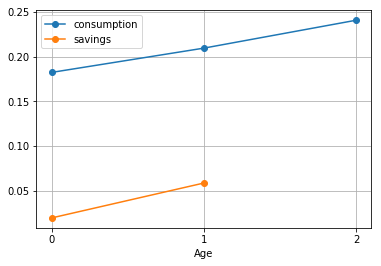

{'C_ss': 0.6329006729395864,
 'EulErr_ss': [-1.3926637620897964e-12, 2.6290081223123707e-12],
 'K_ss': 0.07772362575316386,
 'RCerr_ss': 8.326672684688674e-17,
 'Y_ss': 0.6827603788602411,
 'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': array([0.18241213, 0.20961468, 0.24087387]),
 'r_ss': 2.433062339127069,
 'ss_time': 0.000528000000000084,
 'w_ss': 0.20172465739052575}

In [7]:
n = np.array([1, 1, .2])
parameters = [.442, 3, n, sum(n), 1, .35, .6415, 1e-6]
bvec = np.array([0.1, 0.1])
graph = True

steadystate = get_SS(parameters, bvec, graph)
steadystate

Moving $\beta\uparrow$:

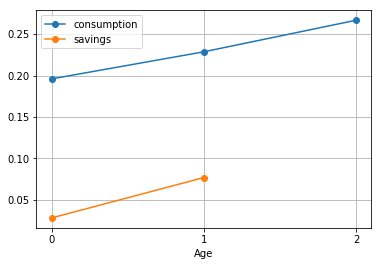

{'C_ss': 0.6912842903551526,
 'EulErr_ss': [6.87805368215777e-12, 2.5295321393059567e-12],
 'K_ss': 0.1050423702259807,
 'RCerr_ss': 9.71445146547012e-17,
 'Y_ss': 0.7586689708551193,
 'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': array([0.19597528, 0.22861594, 0.26669307]),
 'r_ss': 1.8863765057189819,
 'ss_time': 0.0006829999999999892,
 'w_ss': 0.22415219593446706}

In [8]:
parameters = [.55, 3, n, sum(n), 1, .35, .6415, 1e-6]
steadystate_b = get_SS(parameters, bvec, graph)
steadystate_b

They'll consume more in the future because they are more patient and they save more.

### Exercise 2.3

In [19]:
# define utility function and its derivative
def u(c, gamma):
    if c <= 0:
        return -9999999
    else:
        f = (c**(1-gamma) - 1) / (1 - gamma)
        return f

def du(c, gamma):
    if c <= 0:
        return -9999999
    else:
        df = c ** (-gamma)
        return df

# define function to get the interest rates
def get_ri(K, par):
    beta, sigma, nvec, L, A, alpha, delta, tol, T, xi = par
    r = alpha * A * (L/K)**(1-alpha) - delta
    return r

# define function to get the wage rate
def get_wi(K, par):
    beta, sigma, nvec, L, A, alpha, delta, tol, T, xi = par
    w = (1-alpha) * A * (K/L)**alpha
    return w

# define function to get the consumptions
def get_ci(b, w, r, par):
    beta, sigma, nvec, L, A, alpha, delta, tol, T, xi = par

    c = np.empty((3,))
    c[0] = w[0] * nvec[0] - b[0]
    c[1] = w[1] * nvec[1] + (1+r[0]) * b[0] - b[1]
    c[2] = w[2] * nvec[2] + (1+r[1]) * b[1]
    
    return c

# define system of Euler equations
def euler_eqi(b_guess, argum):
    p, w, r = argum
    beta, sigma, nvec, L, A, alpha, delta, tol, T, xi = p
    
    c = get_ci(b_guess, w, r, p)
    eq = [du(c[0], sigma) - beta*(1+r[0])*du(c[1], sigma),
          du(c[1], sigma) - beta*(1+r[1])*du(c[2], sigma)]
    
    return eq

# define time path iteration function to solve for the non-steady state equilibrium
def TPI(b_init, params):
    # unpack parameters
    beta, sigma, nvec, L, A, alpha, delta, tol, T, xi = params
    
    # define max number of iteration
    niter_max = 1000
    nit = 0
    
    # linear initial guess for capital
    steadystate = get_SS(parameters[:-2], b_init[0,:], False)
    k_ss = steadystate['K_ss']
    b_ss = steadystate['b_ss']
    k_start = sum(b_init[0,:])
    ki = np.linspace(k_start, k_ss, T)
    
    # iteration till convergence
    while nit <= niter_max:
        # get interest and wage rates
        wi = get_wi(ki, params)
        ri = get_ri(ki, params)

        bi = np.empty([T,2])
        bi[:,0] = np.ones((T,))*b_ss[0]
        bi[:,1] = np.ones((T,))*b_ss[1]
        bi[0,:] = b_init[0,:]
        euler1 = lambda x: du(wi[0]*nvec[1] + (1+ri[0])*bi[0,0] - x, sigma) - beta*(1+ri[1])*du(wi[1]*nvec[2]+(1+ri[1])*x, sigma)
        b3 = optimize.root(euler1, bi[0,1])
        bi[1,1] = b3.x
        for t in range(1,T-1):
            bi_start = np.array([bi[t-1,0], bi[t,1]])
            arguments = [params, wi[t-1:t+2], ri[t:t+2]]
            bi_solve = optimize.root(euler_eqi, bi_start, args=arguments)
            bi[t,0] = bi_solve.x[0]
            bi[t+1,1] = bi_solve.x[1]

        kip = np.sum(bi, axis=1)
        
        err = sqrt(sum((kip - ki)**2))
        
        if err <= tol:
            print("Converged after ", nit, " iterations.")
            
            plt.plot(range(T), kip)
            plt.xlabel("Periods")
            plt.ylabel("Capital")
            plt.show()
            
            plt.plot(range(T), bi[:,0], label="young agent")
            plt.plot(range(T), bi[:,1], label="middle-age agent")
            plt.xlabel("Periods")
            plt.ylabel("Savings")
            plt.legend()
            plt.show()
            
            return kip, bi, nit
        else:
            ki = xi*kip + (1-xi)*ki
            b_init = bi
            nit += 1

Converged after  118  iterations.


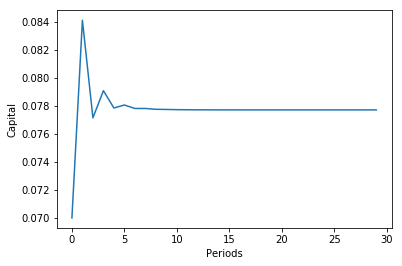

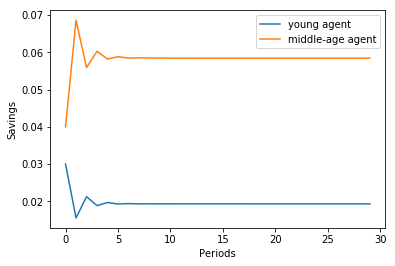

In [26]:
T = 30
tol = 1e-8
n = np.array([1, 1, .2])
xi = .2
parameters = [.442, 3, n, sum(n), 1, .35, .6415, tol, T, xi]

bvec = np.array([0.03, 0.04])  # feasible allocation
b_init = np.empty((T,2))
b_init[:,0] = np.ones((T,))*bvec[0]
b_init[:,1] = np.ones((T,))*bvec[1]

k_new, b_new, niter = TPI(b_init, parameters)

